# Predicting Wind Speed

**Group Members:**

*   Reiden Webber, rwebber7
*   Juntae Park, jpark3068



## Introduction 

Wind speed has much more impact than what we would think - the strong wind could cause natural disasters such as typhoons and tornados [1], while an ideal range of wind speed (which is above 9 miles per hour or above) can maximize wind power that produces renewable energy [2]. In the past, there has been some research on wind speed prediction using measurements from neighboring locations and combining the extreme learning machine and the AdaBoost algorithm [3]. Now, our goal is to train a model using neural network by utilizing linear layers and ReLU functions that can 
predict wind speed based on multiple factors such as precipitation, maximum temperature, minimum temperature, and minimum grass temperature. Our data set includes 6574 days of average wind speed as well as those factors mentioned above. Eventually, once we have a model to predict wind speed, we could use it in various fields - for instance, we could possibly anticipate a big natural disaster coming, or find an ideal location to implement wind turbines. 


<br>

<< citations >>

[1] Statistical Summary and Case Studies of Strong Wind Damage in China. https://www.researchgate.net/publication/289575580_Statistical_Summary_and_Case_Studies_of_Strong_Wind_Damage_in_China. 

[2] “U.S. Energy Information Administration - EIA - Independent Statistics and Analysis.” Where Wind Power Is Harnessed - U.S. Energy Information Administration (EIA), https://www.eia.gov/energyexplained/wind/where-wind-power-is-harnessed.php. 

[3] Wang, Lili, et al. “Wind Speed Prediction Using Measurements from Neighboring Locations and Combining the Extreme Learning Machine and the ADABOOST Algorithm.” Energy Reports, Elsevier, 6 Jan. 2022, https://www.sciencedirect.com/science/article/pii/S2352484721015018. 




# Imports

In [ ]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import sklearn.metrics as metrics

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

# Loading Data

In [ ]:
data = pd.read_csv("wind_dataset.csv")
data["DATE"] = pd.to_datetime(data.DATE, format="%Y-%m-%d")
data = data.set_index('DATE')
data = data.interpolate()

# Feature Analysis

In [ ]:
data_col = ["WIND","RAIN","T.MAX","T.MIN", "T.MIN.G"]

data_7d_roll = data[data_col].rolling(window=7, center=True).mean()
data_365d_roll = data[data_col].rolling(window=365, center=True).mean()

## Wind Trends

Text(0.5, 1.0, 'Trends in Wind Speed')

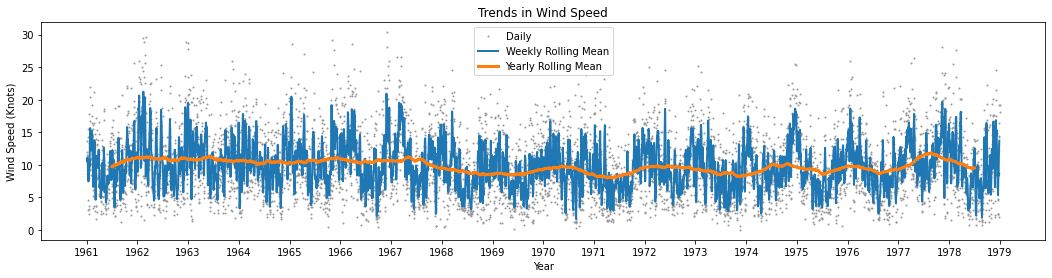

In [ ]:
fig, ax = plt.subplots(figsize = (18,4))
column = 'WIND'
ax.plot(data[column], marker='.', color='0.6', markersize=2, linestyle='None', label='Daily') # daily data
ax.plot(data_7d_roll[column], linewidth=2, label='Weekly Rolling Mean') # 7-day rolling data
ax.plot(data_365d_roll[column], linewidth=3, label='Yearly Rolling Mean') # annual rolling data

# graph formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Wind Speed (Knots)')
ax.set_title('Trends in Wind Speed')

## Temperature Trends



### Max Temperature

Text(0.5, 1.0, 'Trends in Max Temperature')

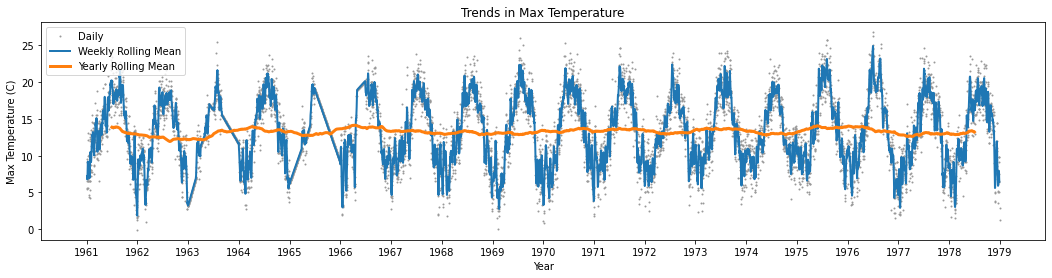

In [ ]:
fig, ax = plt.subplots(figsize = (18,4))
column = 'T.MAX'
ax.plot(data[column], marker='.', color='0.6', markersize=2, linestyle='None', label='Daily') # daily data
ax.plot(data_7d_roll[column], linewidth=2, label='Weekly Rolling Mean') # 7-day rolling data
ax.plot(data_365d_roll[column], linewidth=3, label='Yearly Rolling Mean') # annual rolling data

# graph formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Max Temperature (C)')
ax.set_title('Trends in Max Temperature')

### Minimum Temperature

Text(0.5, 1.0, 'Trends in Minimum Temperature')

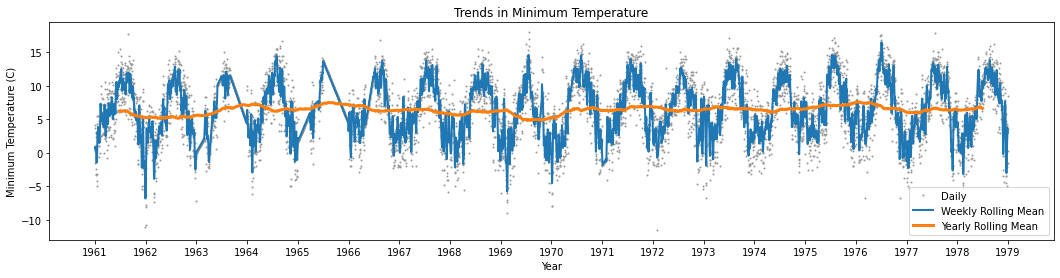

In [ ]:
fig, ax = plt.subplots(figsize = (18,4))
column = 'T.MIN'
ax.plot(data[column], marker='.', color='0.6', markersize=2, linestyle='None', label='Daily') # daily data
ax.plot(data_7d_roll[column], linewidth=2, label='Weekly Rolling Mean') # 7-day rolling data
ax.plot(data_365d_roll[column], linewidth=3, label='Yearly Rolling Mean') # annual rolling data

# graph formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Minimum Temperature (C)')
ax.set_title('Trends in Minimum Temperature')

### Minimum Ground Temperature

Text(0.5, 1.0, 'Trends in Minimum Ground Temperature')

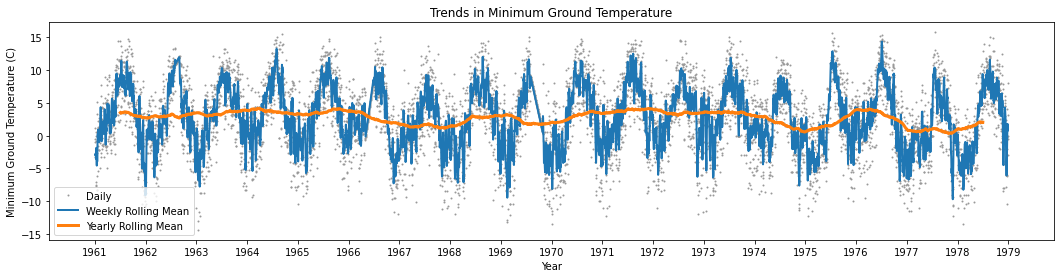

In [ ]:
fig, ax = plt.subplots(figsize = (18,4))
column = 'T.MIN.G'
ax.plot(data[column], marker='.', color='0.6', markersize=2, linestyle='None', label='Daily') # daily data
ax.plot(data_7d_roll[column], linewidth=2, label='Weekly Rolling Mean') # 7-day rolling data
ax.plot(data_365d_roll[column], linewidth=3, label='Yearly Rolling Mean') # annual rolling data

# graph formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Minimum Ground Temperature (C)')
ax.set_title('Trends in Minimum Ground Temperature')

## Precipitation Trends

Text(0.5, 1.0, 'Trends in Precipitation')

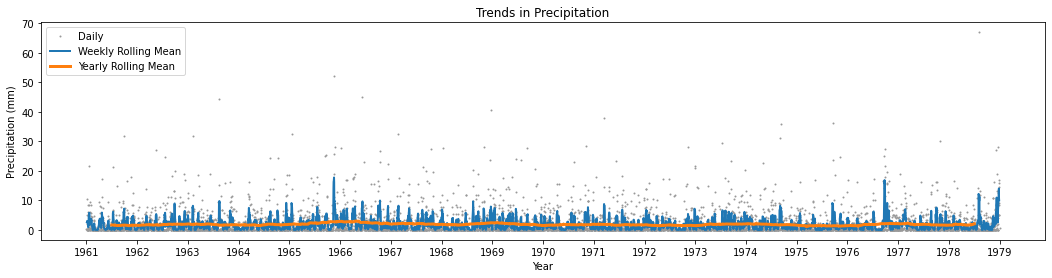

In [ ]:
fig, ax = plt.subplots(figsize = (18,4))
column = 'RAIN'
ax.plot(data[column], marker='.', color='0.6', markersize=2, linestyle='None', label='Daily') # daily data
ax.plot(data_7d_roll[column], linewidth=2, label='Weekly Rolling Mean') # 7-day rolling data
ax.plot(data_365d_roll[column], linewidth=3, label='Yearly Rolling Mean') # annual rolling data

# graph formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Trends in Precipitation')

# Feature Engineering

In [ ]:
data_wind = data[['WIND']]
data_wind.loc[:,'Wind_1d_prev'] = data_wind.loc[:,'WIND'].shift()
data_wind.loc[:,'Wind_1d_diff'] = data_wind.loc[:,'Wind_1d_prev'].diff()
data_wind.loc[:,'Wind_7d_prev'] = data_wind.loc[:,'WIND'].shift(7)
data_wind.loc[:,'Wind_7d_diff'] = data_wind.loc[:,'Wind_7d_prev'].diff()
data_wind = data_wind.dropna()

In [ ]:
data_tmax = data[['T.MAX']]
data_tmax.loc[:,'Tmax_1d_prev'] = data_tmax.loc[:,'T.MAX'].shift()
data_tmax.loc[:,'Tmax_1d_diff'] = data_tmax.loc[:,'Tmax_1d_prev'].diff()
data_tmax.loc[:,'Tmax_7d_prev'] = data_tmax.loc[:,'T.MAX'].shift(7)
data_tmax.loc[:,'Tmax_7d_diff'] = data_tmax.loc[:,'Tmax_7d_prev'].diff()

data_tmax = data_tmax.dropna()

In [ ]:
data_tmin = data[['T.MIN']]
data_tmin.loc[:,'Tmin_1d_prev'] = data_tmin.loc[:,'T.MIN'].shift()
data_tmin.loc[:,'Tmin_1d_diff'] = data_tmin.loc[:,'Tmin_1d_prev'].diff()
data_tmin.loc[:,'Tmin_7d_prev'] = data_tmin.loc[:,'T.MIN'].shift(7)
data_tmin.loc[:,'Tmin_7d_diff'] = data_tmin.loc[:,'Tmin_7d_prev'].diff()

data_tmin = data_tmin.dropna()

In [ ]:
data_tming = data[['T.MIN.G']]
data_tming.loc[:,'TminG_1d_prev'] = data_tming.loc[:,'T.MIN.G'].shift()
data_tming.loc[:,'TminG_1d_diff'] = data_tming.loc[:,'TminG_1d_prev'].diff()
data_tming.loc[:,'TminG_7d_prev'] = data_tming.loc[:,'T.MIN.G'].shift(7)
data_tming.loc[:,'TminG_7d_diff'] = data_tming.loc[:,'TminG_7d_prev'].diff()

data_tming = data_tming.dropna()

In [ ]:
features = data_wind.join(data_tmax).join(data_tmin).join(data_tming).join(data[['RAIN']])
print(features)

             WIND  Wind_1d_prev  Wind_1d_diff  Wind_7d_prev  Wind_7d_diff  \
DATE                                                                        
1961-01-09   8.04         14.29          5.12         11.50         -2.17   
1961-01-10  11.42          8.04         -6.25         11.25         -0.25   
1961-01-11   7.54         11.42          3.38          8.63         -2.62   
1961-01-12  15.54          7.54         -3.88         11.92          3.29   
1961-01-13   4.63         15.54          8.00         10.67         -1.25   
...           ...           ...           ...           ...           ...   
1978-12-27  14.46          1.96         -6.75          4.54         -0.21   
1978-12-28  14.33         14.46         12.50         11.67          7.13   
1978-12-29  19.17         14.33         -0.13          2.46         -9.21   
1978-12-30  18.08         19.17          4.84         16.50         14.04   
1978-12-31  19.25         18.08         -1.09         12.25         -4.25   

# Training and Testing

In [ ]:
X_train = features.loc[:'1973'].drop(['WIND'], axis = 1)
y_train = features.loc[:'1973', 'WIND']
X_test = features.loc['1974' : '1978'].drop(['WIND'], axis = 1)
y_test = features.loc['1974' : '1978', 'WIND']

scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

LR: 0.360378 (0.080208)
KNN: 0.175109 (0.086141)
RF: 0.326571 (0.083994)
SVR: 0.325909 (0.094470)
Ada: 0.255191 (0.103509)
GB: 0.372099 (0.085524)


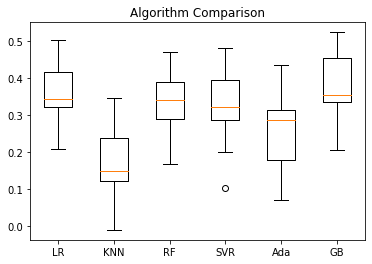

In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 16)))
models.append(('SVR', SVR(gamma='auto')))
models.append(('Ada', AdaBoostRegressor()))
models.append(('GB', GradientBoostingRegressor()))

results = []
names = []
for name, model in models:
 tscv = TimeSeriesSplit(n_splits=16)
    
 cv_results = cross_val_score(model, X_scaled, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
def regression_results(y_true, y_pred):
    mse = metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)
    print('r2: ', round(r2,4))
    print('MSE: ', round(mse,4))

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_test)
print('Linear Algorithm:')
regression_results(y_test.values, lin_pred)

knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print('K-Nearest Neighboors Algorithm:')
regression_results(y_test.values, knn_pred)

rfr = RandomForestRegressor(max_depth=2, random_state=0)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)
print('Random Forest Algorithm:')
regression_results(y_test.values, rfr_pred)

ada = AdaBoostRegressor(random_state=0, n_estimators=100)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)
print('AdaBoost Algorithm:')
regression_results(y_test.values, ada_pred)

gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
print('Gradient Boost Algorithm:')
regression_results(y_test.values, gbr_pred)

Linear Algorithm:
r2:  0.4338
MSE:  13.3453
K-Nearest Neighboors Algorithm:
r2:  0.1013
MSE:  21.183
Random Forest Algorithm:
r2:  0.3652
MSE:  14.9635
AdaBoost Algorithm:
r2:  0.2784
MSE:  17.0095
Gradient Boost Algorithm:
r2:  0.44
MSE:  13.1991


# Neural Network

## Datasets and Dataloaders

In [ ]:
class WindDataset(Dataset):
  def __init__(self, x, y):
    x = x.values
    y = y.values
    self.x_tensor = torch.tensor(x,dtype=torch.float32)
    self.y_tensor = torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_tensor)
   
  def __getitem__(self,idx):
    return self.x_tensor[idx],self.y_tensor[idx]

In [ ]:
train_dataset=WindDataset(X_train, y_train)
train_loader= DataLoader(train_dataset,batch_size=7,shuffle=False)
test_dataset=WindDataset(X_test, y_test)

## Defining the Neural Network Model


In [ ]:
class MultiLayerNN(nn.Module):
    def __init__(self, input_dim = 20, output_dim = 1):
        super(MultiLayerNN, self).__init__()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(input_dim, 40),
            nn.ReLU(),
            nn.Linear(40, 30),
            nn.ReLU(),
            nn.Linear(30, output_dim)
        )
    
    def forward(self, input):
        output = self.linear_sigmoid_stack(input)
        return output

In [ ]:
# Training the model

def train_model(model, trainloader, num_epochs = 10):

  loss_func = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  size = len(trainloader.dataset)

  for epoch in range(num_epochs):
    for batch, (train_feat, train_label) in enumerate(trainloader):
      yhat = model(train_feat)
      loss = loss_func(yhat, train_label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
    if epoch % 10 == 0:
      print(f"epoch:{epoch:>3d}/{num_epochs}")

  print('Training process has finished.')

In [ ]:
def test_model(model, input_test):
    model.eval()

    with torch.no_grad():
      y_test_preds = model(input_test.x_tensor)
      target_list = input_test.y_tensor

    print("Neural Network Model:")
    print("Test MSE      : {}".format(metrics.mean_squared_error(target_list, y_test_preds)))
    print("Test R2 Score : {}".format(metrics.r2_score(target_list, y_test_preds)))

In [ ]:
nn_clf = MultiLayerNN()
train_model(nn_clf, train_loader, 100)
test_model(nn_clf, test_dataset)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:  0/100
epoch: 10/100
epoch: 20/100
epoch: 30/100
epoch: 40/100
epoch: 50/100
epoch: 60/100
epoch: 70/100
epoch: 80/100
epoch: 90/100
Training process has finished.
Neural Network Model:
Test MSE      : 17.172754287719727
Test R2 Score : 0.2714388622245262
